## CSCA 5622. Final Project

## Predicting wine quality based on the chemical properties

In this project we will be trying to predict the quality of wine samples looking at the pure chemical characteristics. Characteristics are continuous floating point numbers, quality is measured in numerical scale 3-9 (worst-to-best), this makes it a regression problem. Two methods to be tried: *Linear Regression* and *Gradient Boost Regression*.

I will be following these steps:
* Load and explore the dataset
* Analyze and clean it, drop outliers
* Check if there is feature-collinearity
* Split dataset into training (80%) and test (20%) parts.
* Train/tune Linear Regression
* Train/tune Gradient Boost Regression
* Compare and analyze results

### Dataset Information
Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests. https://archive.ics.uci.edu/dataset/186/wine+quality


### Additional Information
The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Data consists of two datasets with characteristics of red and white wines.

By P. Cortez, A. Cerdeira, Fernando Almeida, Telmo Matos, J. Reis. 2009

## Data cleaning, EDA

Since both datasets (red and white wines) are structurally identical it makes sense mixing them together, to train morels which predict both red and white wines quality. There could be some statistical challenges since different color groups may have different distribution of chemical characteristics though.

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.tools.eval_measures import rmse
import statsmodels.formula.api as smf
from functools import reduce
import operator
import itertools


In [2]:
wines_red = pd.read_csv('./data/winequality-red.csv', sep=';')
wines_white = pd.read_csv('./data/winequality-white.csv', sep=';')

# Dump a few rows from one of the datasets
wines_red.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [3]:
# The second dataset has absolutely identical structure
# let's just concatenate them and take a look at the statistical properties

wines = pd.concat([wines_red, wines_white], ignore_index=True)
wines.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378  
std       0.160787     0.148806     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

The dataset is dense (complete), there are no missing values. If there were some, then it would be a case by case decision to keep them with imputed defaults or just drop them if the samples look corrupted.

In [4]:
# No missing values!
print(wines.isna().any().any())

False


Two features correlating the most with the target quality are: `alcohol` and `density`, but scattering along these dimensions doesn't easily reveal any helpful regularities. We can also see that there are very few "bad" and "exceptional" wines, the majority is in the range 4-8.

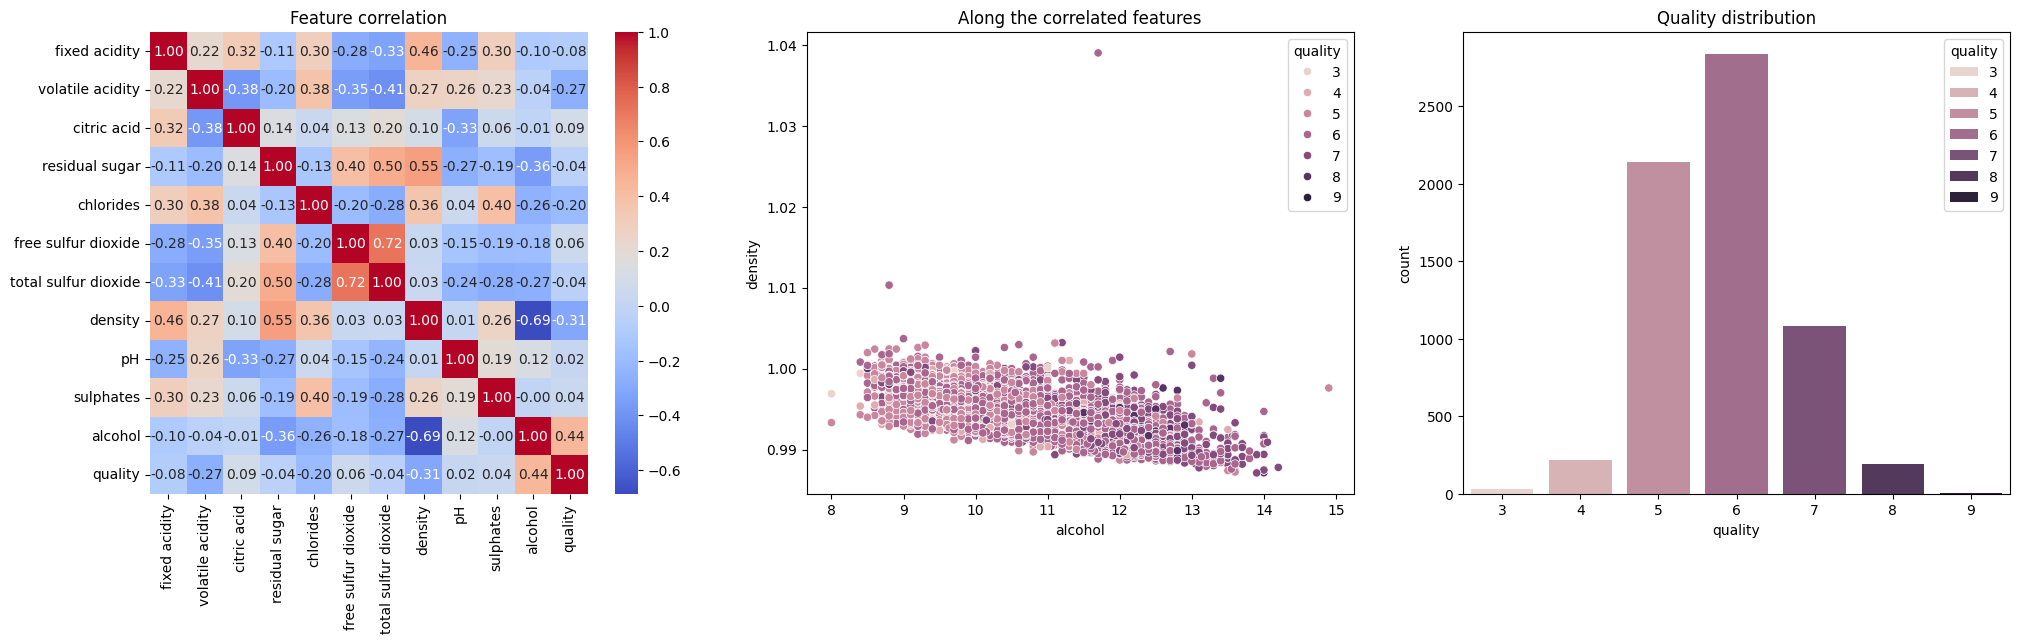

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
sns.heatmap(wines.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0])
sns.scatterplot(x='alcohol', y='density', hue='quality', data=wines, ax=axes[1])
sns.countplot(data=wines, x='quality', ax=axes[2], hue='quality')
axes[0].set_title("Feature correlation")
axes[1].set_title("Along the correlated features")
axes[2].set_title("Quality distribution")
plt.show()

Features correlating with the target `quality` variable are:
* alcohol: 0.44
* density: -0.31
* volatile acidity: -0.27


At the pairplot it's easy to spot quite a lot of outliers - samples laying far away from the general population

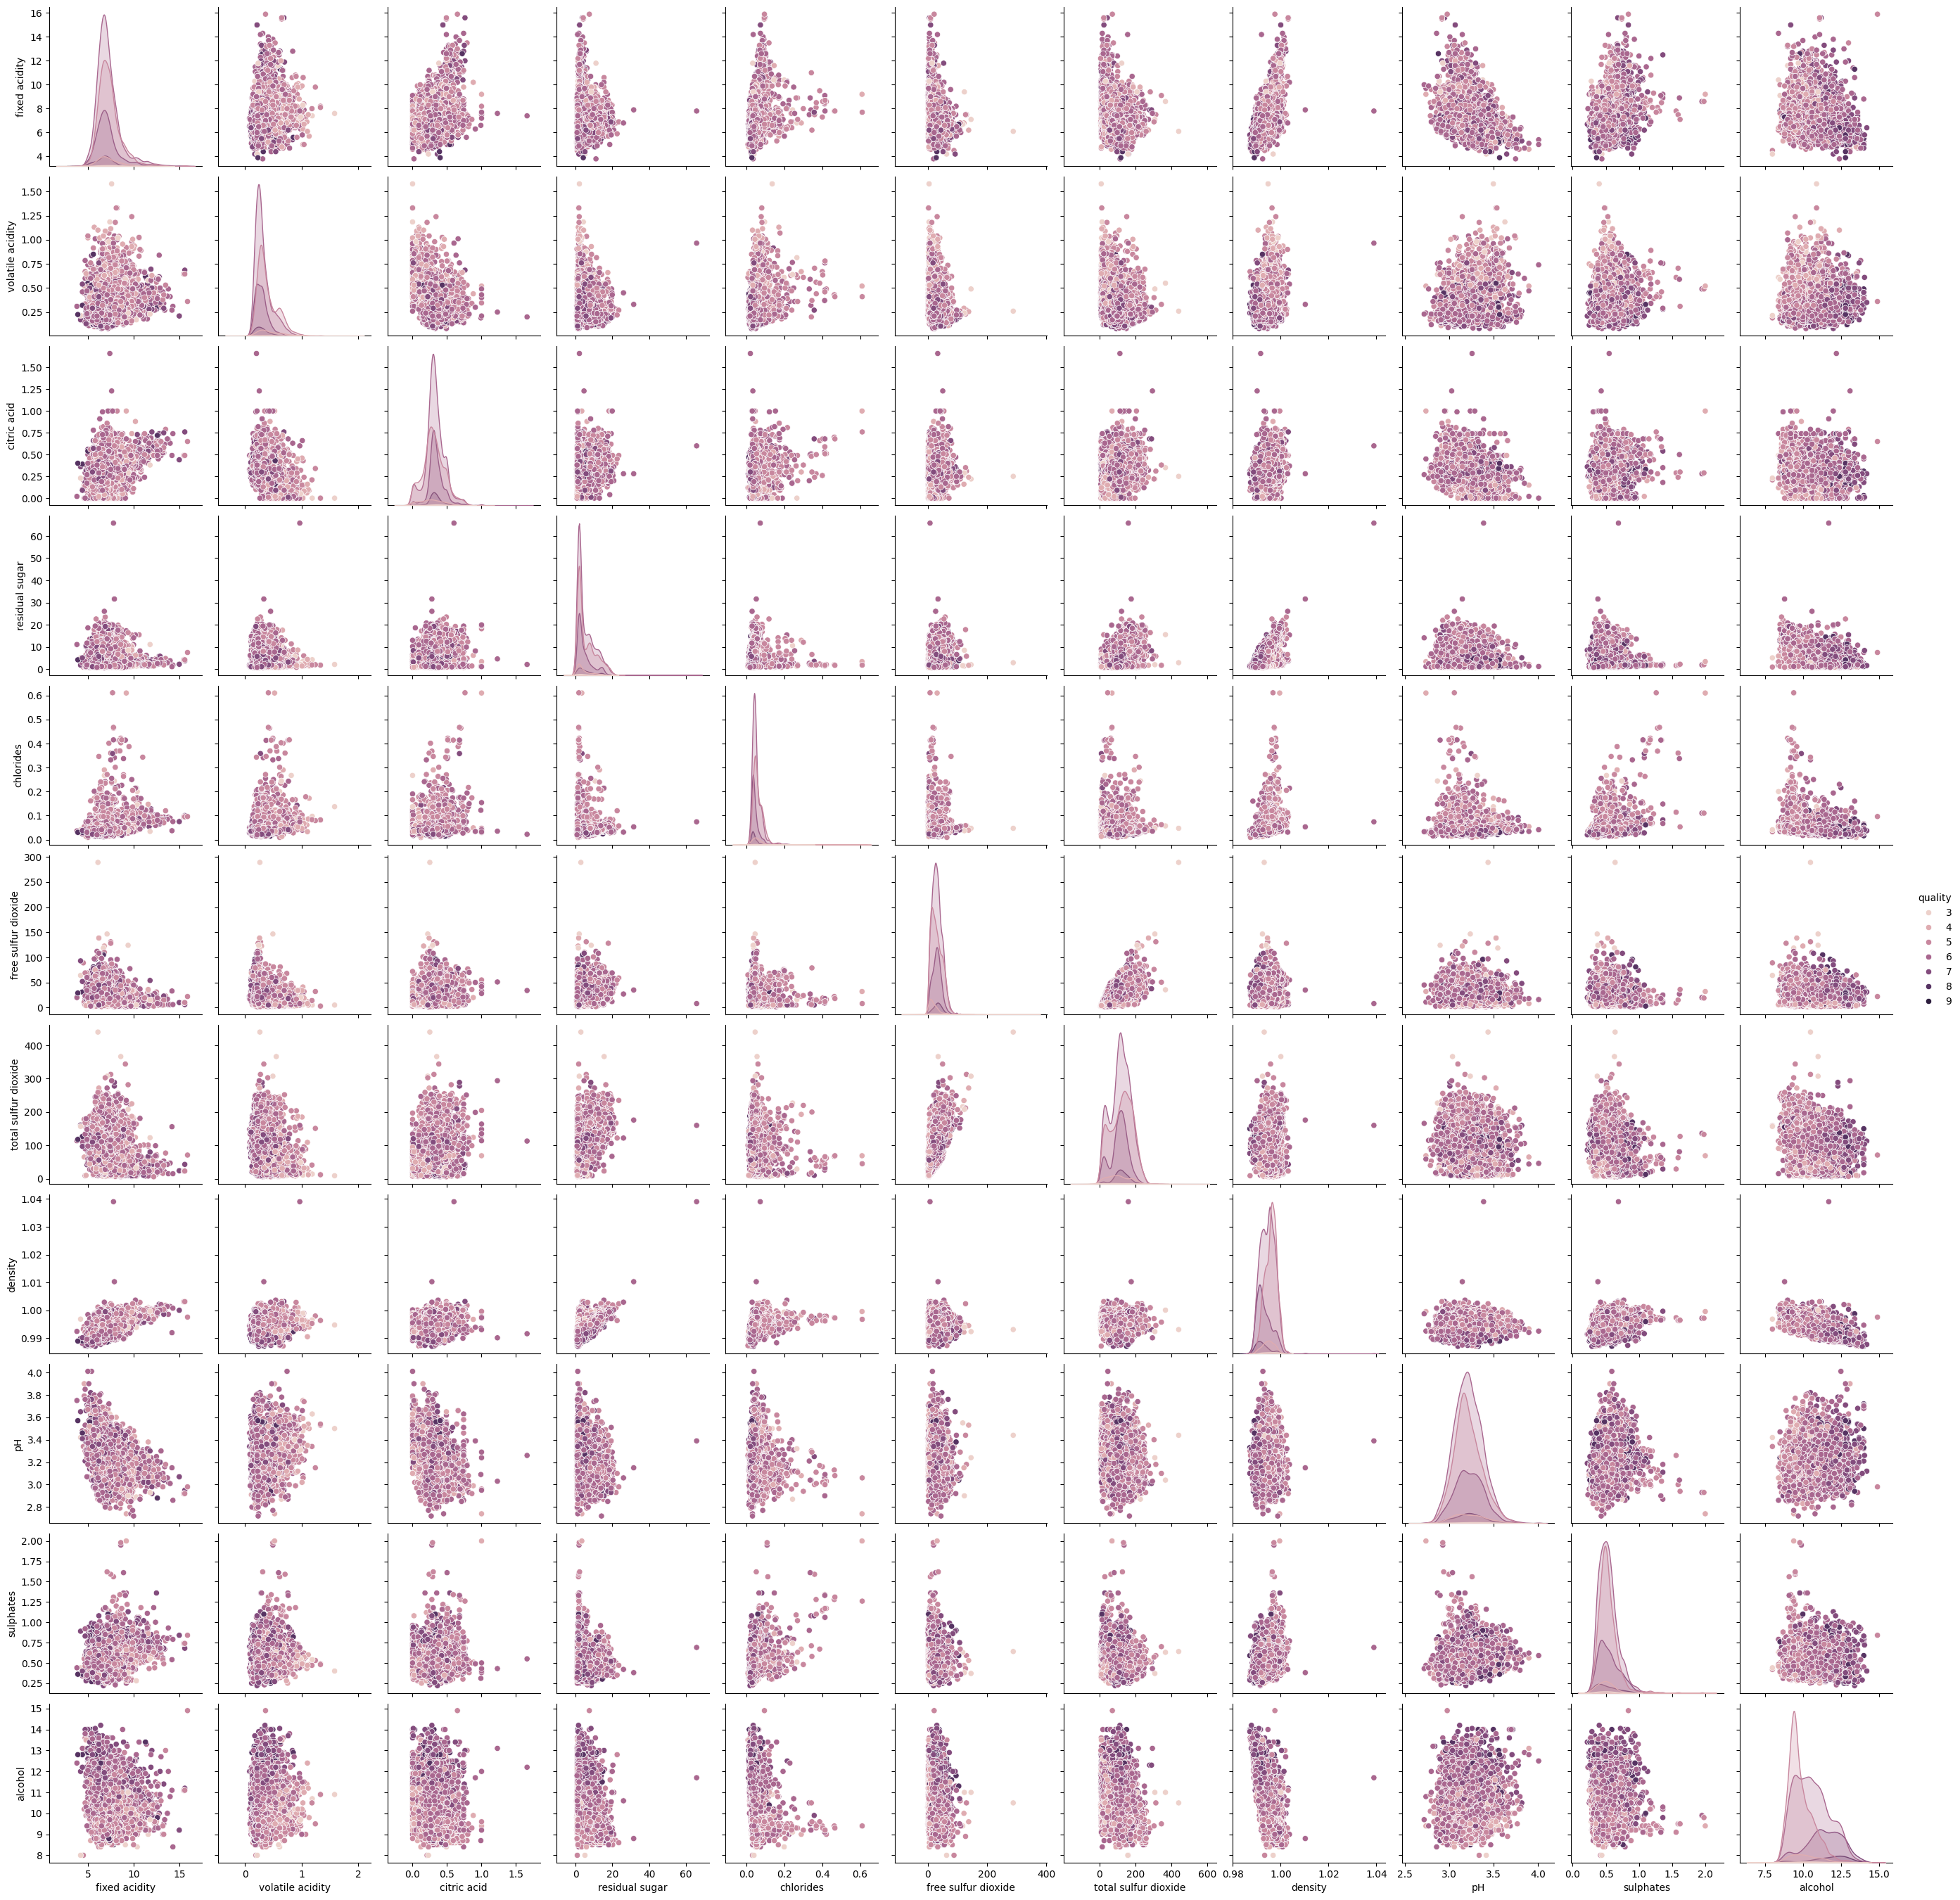

In [6]:
sns.pairplot(wines, diag_kind='kde', hue='quality')

Models will likely overfit trying to account for the outliers, it makes sense to strip them from training. But defining and identifying them is another problem per se. If all the features were distributed normally (Gaussian), then everything out of the 3 sigma range could be called an "outlier", but the distributions here are not all normal. Let's just try different multipliers and see how many of the records are affected.

['3*std = 488 (7.51%)', '4*std = 188 (2.89%)', '5*std = 77 (1.19%)', '6*std = 49 (0.75%)', '7*std = 31 (0.48%)', '8*std = 28 (0.43%)', '9*std = 20 (0.31%)', '10*std = 13 (0.20%)']


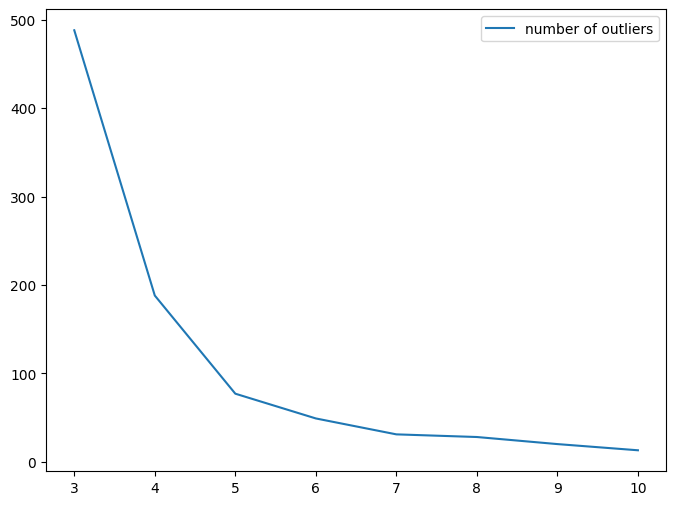

In [7]:
def out_of_k_sigmas(df, df_colums, k):
    conditions = [np.abs(df[c] - df[c].mean()) > k * df[c].std() for c in df_colums]
    return reduce(operator.or_, conditions)

k_sigmas = range(3,11)
n_outliers = []
for k in k_sigmas:
    mask = out_of_k_sigmas(wines, wines.columns[:-1], k)
    n_outliers.append(np.sum(mask))

print([f'{k}*std = {n} ({100*(n/wines.shape[0]):.2f}%)' for k,n in zip(k_sigmas, np.array(n_outliers))])

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(x=k_sigmas, y=n_outliers, label='number of outliers', ax=axes)
plt.show()

From the pairplot I could identify only a few dozen suspicious samples, this would justify picking k=8 or k=9.

In [8]:
mask = out_of_k_sigmas(wines, wines.columns[:-1], k=8)
print(wines[mask].shape[0])

# let's dump the outliers to visually confirm
wines[mask].head()


# We can reiterate plotting the pairplot
#
#     sns.pairplot(wines[~mask], diag_kind='kde', hue='quality')
#
# until all the suspicious records are eliminated. Here it looks like k==8 is enough, the remaining outliers are not that much off

28


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
17            8.1              0.56         0.28             1.7      0.368   
19            7.9              0.32         0.51             1.8      0.341   
81            7.8              0.43         0.70             1.9      0.464   
83            7.3              0.67         0.26             1.8      0.401   
86            8.6              0.49         0.28             1.9      0.110   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
17                 16.0                  56.0   0.9968  3.11       1.28   
19                 17.0                  56.0   0.9969  3.04       1.08   
81                 22.0                  67.0   0.9974  3.13       1.28   
83                 16.0                  51.0   0.9969  3.16       1.14   
86                 20.0                 136.0   0.9972  2.93       1.95   

    alcohol  quality  
17      9.3        5  
19      9.2        6  
81      9.4        5  
83      9.4        5  
86      9.9        6

In [9]:
# Make the column names convenient for OLS
wines.columns = wines.columns.str.replace(' ', '_')
ouliers = wines[mask]
inliners = wines[~mask]

# Keep only "good" samples down the road, and deterministically split the inliers as 80% for training, 20% for testing
df = inliners
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0)


## Models


### 1. Linear Regression


From the pairplots it's quite clear that no easy linear combination can predict the quality accurately enough. Let's add nonlinear terms and interactions and see which of them are "approved" by the model (improve the prediction accuracy the most).

In [10]:
basic_predictors = set(df.columns[:-1])
cu_roots = {f'np.power({p}, 0.333)' for p in basic_predictors}
sq_roots = {f'np.power({p}, 0.5)' for p in basic_predictors}
squares = {f'np.power({p}, 2)' for p in basic_predictors}
cubes = {f'np.power({p}, 3)' for p in basic_predictors}
interactions = set((a + ':' + b) for a, b in list(itertools.combinations(basic_predictors, 2)))
all_predictors = basic_predictors | cu_roots | sq_roots | squares | cubes | interactions

print("Total number of predictors to probe:", len(all_predictors))

Total number of predictors to probe: 110


Add the most promising predictors in order of increasing Adjusted R2 the most. Retain statistics

In [22]:
remaining_predictors = all_predictors.copy()

best_models = []
rmses_train = []
rmses_test = []
r2s_adj = []

function = 'quality ~ '
while remaining_predictors:

    best_function = ''
    best_predictor = ''
    best_r2_adj = 0
    best_model = None

    for p in remaining_predictors:
        f = function + ' + ' + p
        model = smf.ols(f, data=df_train).fit()

        if model.rsquared_adj > best_r2_adj:
            best_r2_adj = model.rsquared_adj
            best_model = model
            best_function = f
            best_predictor = p

    function = best_function
    remaining_predictors.remove(p)

    yhat_train = best_model.predict(df_train)
    yhat_test = best_model.predict(df_test)
    rmse_train = rmse(yhat_train, df_train['quality'])
    rmse_test = rmse(yhat_test, df_test['quality'])

    best_models.append(best_model)
    r2s_adj.append(best_r2_adj)
    rmses_train.append(rmse_train)
    rmses_test.append(rmse_test)

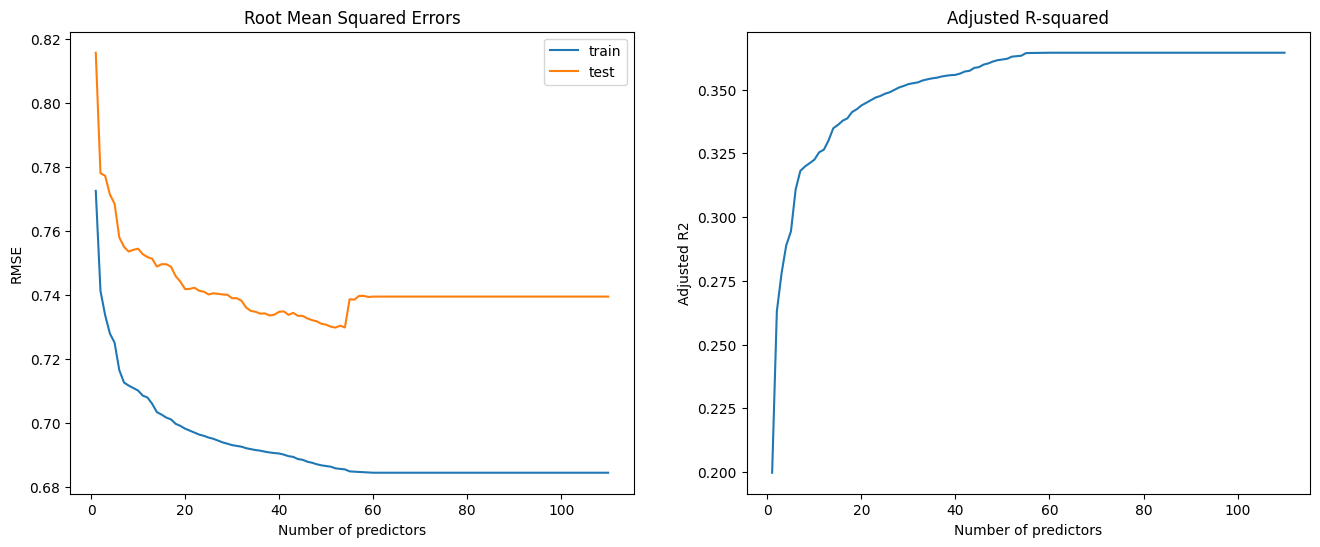

In [23]:
n = len(rmses_test)
r = range(1, n+1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x=r, y=rmses_train, label='train', ax=axes[0])
sns.lineplot(x=r, y=rmses_test, label='test', ax=axes[0])
sns.lineplot(x=r, y=r2s_adj, ax=axes[1])

axes[0].set_title('Root Mean Squared Errors')
axes[0].set_xlabel('Number of predictors')
axes[0].set_ylabel('RMSE')
axes[1].set_title('Adjusted R-squared')
axes[1].set_xlabel('Number of predictors')
axes[1].set_ylabel('Adjusted R2')
plt.show()


It stopped improving after approximately 60th iteration, but test RMSE doesn't climb up, so technically I can't say that adding more terms leads to "overfitting", they are just not leading to significant gains.

Taking a look at the model created on the 5-th iteration. It picked predictors which wouldn't have easy and trivial explanations: $alcohol^2$, $\sqrt[3]{volatile\_axidity}$, $suplhates*pH$, $\sqrt[3]{residual\_sugar}$, $sulphates*total\_sulfur\_dioxide$ etc.

In [13]:
best_models[10].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     227.9
Date:                Mon, 13 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:59:05   Log-Likelihood:                -5560.7
No. Observations:                5175   AIC:                         1.115e+04
Df Residuals:                    5163   BIC:                         1.122e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.1371      0.630     -0.218      0.828      -1.371       1.097
np.power(alcohol, 2)                     0.0148      0.000     34.319      0.000       0.014       0.016
np.power(volatile_acidity, 0.333)       -1.4583      0.215     -6.785      0.000      -1.880      -1.037
sulphates:pH                            -0.1066      0.110     -0.969      0.333      -0.322       0.109
np.power(residual_sugar, 0.333)          0.3200      0.039      8.168      0.000       0.243       0.397
sulphates:total_sulfur_dioxide          -0.0125      0.001     -8.736      0.000      -0.015      -0.010
np.power(free_sulfur_dioxide, 0.333)     0.4986      0.045     10.992      0.000       0.410       0.588
np.power(free_sulfur_dioxide, 3)     -6.307e-07   1.04e-07     -6.051      0.000   -8.35e-07   -4.26e-07
free_sulfur_dioxide:volatile_acidity    -0.0200      0.005     -4.114      0.000      -0.029      -0.010
chlorides:residual_sugar                -0.2389      0.069     -3.484      0.000      -0.373      -0.104
np.power(sulphates, 0.333)               5.0137      0.905      5.538      0.000       3.239       6.789
total_sulfur_dioxide:pH                  0.0013      0.000      4.795      0.000       0.001       0.002
==============================================================================
Omnibus:                       90.964   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.225
Skew:                           0.088   Prob(JB):                     4.00e-38
Kurtosis:                       3.876   Cond. No.                     1.56e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Also I notice some statistically insignificant coefficients. Let's just drop them out of the model on 70'th iteration and call it the final model

In [14]:
model = best_models[70]
model_predictors = set(model.params.index)
model_predictors.remove('Intercept')

repeat = True
while True:
    model = smf.ols(f'quality ~ {'+'.join(model_predictors)}', data=df_train).fit()
    pvalues_no_intercept = model.pvalues.drop('Intercept', errors='ignore')
    highest_pvalue_predictor = pvalues_no_intercept.idxmax()
    highest_pvalue = pvalues_no_intercept.max()
    if highest_pvalue < 0.025:
        break
    model_predictors.remove(highest_pvalue_predictor)

final_linear_regression_model = model

How good is the model actually? Let's look at the misses

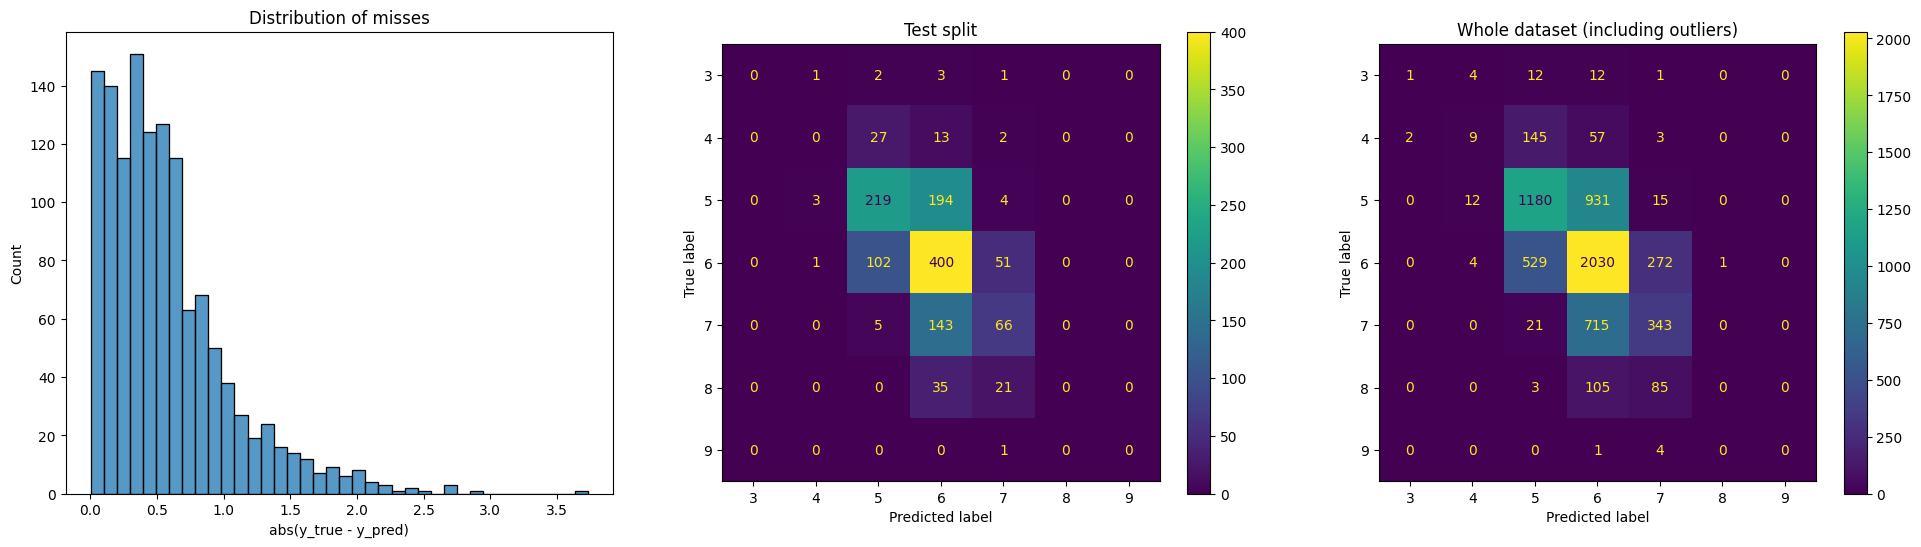

In [15]:
y_test = df_test['quality']
yhat_test = final_linear_regression_model.predict(df_test)

y_wines = wines['quality']
yhat_wines = final_linear_regression_model.predict(wines)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# How much the prediction if off the truth?
d = np.abs(yhat_test - y_test)
sns.histplot(data=d, ax=axes[0])

cm = confusion_matrix(y_test, np.clip(np.round(yhat_test), 3, 9))
ConfusionMatrixDisplay(cm, display_labels=range(3,10)).plot(ax=axes[1])

cm = confusion_matrix(y_wines, np.clip(np.round(yhat_wines), 3, 9))
ConfusionMatrixDisplay(cm, display_labels=range(3,10)).plot(ax=axes[2])

axes[0].set_title('Distribution of misses')
axes[0].set_xlabel('abs(y_true - y_pred)')
axes[1].set_title('Test split')
axes[2].set_title('Whole dataset (including outliers)')
plt.show()

In [16]:
print(f'Total number of params (features): {final_linear_regression_model.params.shape[0]}, test RMSE: {rmse(yhat_test, y_test)}')

Total number of params (features): 41, test RMSE: 0.7399754359294893


### 2. Gradient Boost Regression

The regressor has two main hyperparams: number of estimators (trees) and their max depth. It is generally advised to have a larger number of shallower trees, I was curious if the default `max_depth=3` works best for the wines samples dataset.

I probed 7 different max_dept values 18 different max number of estimator limits, total `18 * 7 = 126` experiments. Here is the setup: 

In [17]:
def run_gb_regressor_probe_n_estimators(probe_n_estimators, X_train, X_test, y_train, y_test, random_state=0, max_depth=3):
    rmses_train = []
    rmses_test = []
    for n in probe_n_estimators:
        reg = GradientBoostingRegressor(n_estimators=n, random_state=random_state, max_depth=max_depth)
        reg.fit(X_train, y_train)

        yhat_train = reg.predict(X_train)
        rmses_train.append(rmse(y_train, yhat_train))
        
        yhat_test = reg.predict(X_test)
        rmses_test.append(rmse(y_test, yhat_test))
    return rmses_train, rmses_test

In [18]:
X_train = df_train[df_train.columns[:-1]]
y_train = df_train[df_train.columns[-1]]
X_test = df_test[df_test.columns[:-1]]
y_test = df_test[df_test.columns[-1]]

probe_n_estimators = [1,2,3,5,10,20,30,50,75,100,200,300,400,500,750,1000,1500,2000]

depth_to_rmse = dict()
depth_to_probe = [2,3,5,7,8,9,10]
for d in depth_to_probe:
    rmse_train, tmse_test = run_gb_regressor_probe_n_estimators(probe_n_estimators, X_train, X_test, y_train, y_test, max_depth=d)
    depth_to_rmse[d] = (rmse_train, tmse_test)

Now plotting RMSE of test and train datasets for each probed depth.

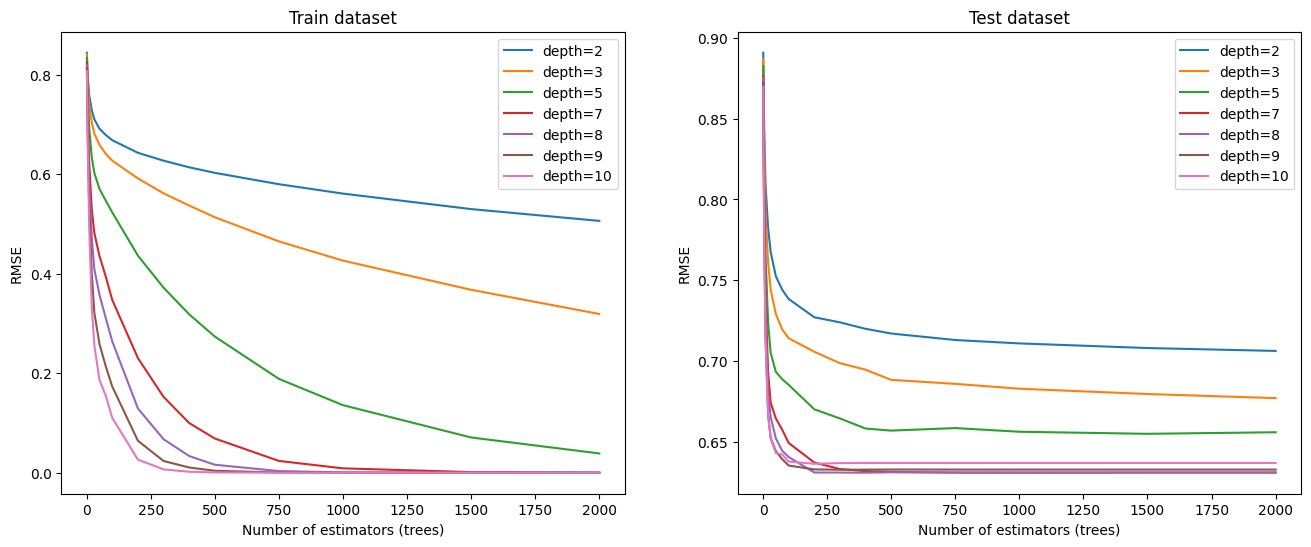

In [19]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for d in depth_to_rmse.keys():
    sns.lineplot(x=probe_n_estimators, y=depth_to_rmse[d][0], label=f'depth={d}', ax=axes[0])
    sns.lineplot(x=probe_n_estimators, y=depth_to_rmse[d][1], label=f'depth={d}', ax=axes[1])

axes[0].set_title('Train dataset')
axes[0].set_xlabel('Number of estimators (trees)')
axes[0].set_ylabel('RMSE')
axes[1].set_title('Test dataset')
axes[1].set_xlabel('Number of estimators (trees)')
axes[1].set_ylabel('RMSE')

plt.show()

In [20]:
idx = probe_n_estimators.index(500)
print(f'rmse={depth_to_rmse[8][1][idx]}')



rmse=0.6309281828617225


From what I see, regressors with the $depth \le 5$ converge to the final RMSE levels which are worse than the levels of $7 \le depth \le 9$ regardless of how many trees probed. As the final model I'm picking the one with `n_estimators=500` and `max_depth=8`.

We can see that it's much more accurate that the *LogisticRegression* model from the previous experiment.

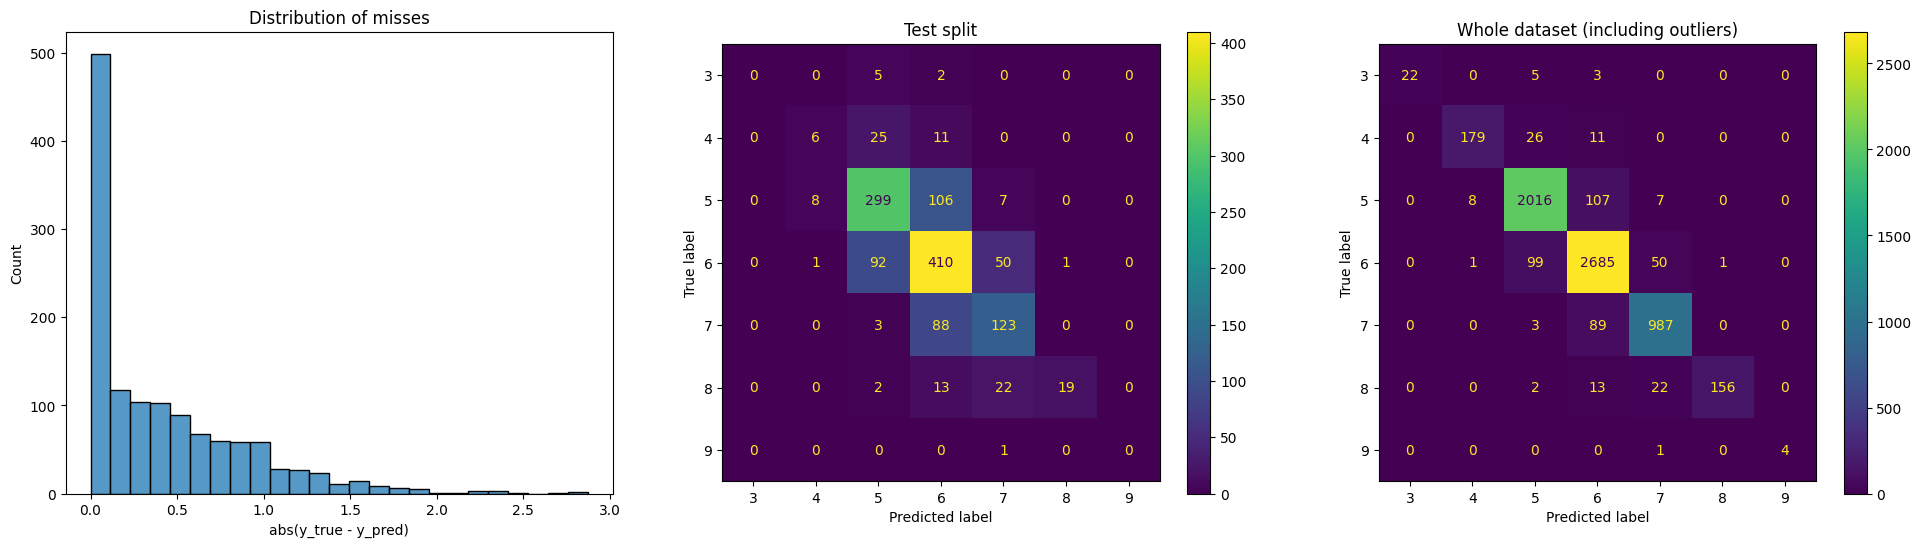

In [21]:
final_gb_regression_model = GradientBoostingRegressor(n_estimators=500, random_state=0, max_depth=8)
final_gb_regression_model.fit(X_train, y_train)

yhat_test = final_gb_regression_model.predict(X_test)

y_wines = wines['quality']
yhat_wines = final_gb_regression_model.predict(wines[wines.columns[:-1]])


fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# How much the prediction if off the truth?
d = np.abs(yhat_test - y_test)
sns.histplot(data=d, ax=axes[0])

cm = confusion_matrix(y_test, np.clip(np.round(yhat_test), 3, 9))
ConfusionMatrixDisplay(cm, display_labels=range(3,10)).plot(ax=axes[1])

cm = confusion_matrix(y_wines, np.clip(np.round(yhat_wines), 3, 9))
ConfusionMatrixDisplay(cm, display_labels=range(3,10)).plot(ax=axes[2])

axes[0].set_title('Distribution of misses')
axes[0].set_xlabel('abs(y_true - y_pred)')
axes[1].set_title('Test split')
axes[2].set_title('Whole dataset (including outliers)')
plt.show()



## Summary

Linear Regression can handle complex datasets but extensive feature engineering is required. Besides the basic features $x_i$ some additional terms like interactions $x_i*x_j$, and different powers $\sqrt[3]x_i$, $\sqrt x_i$, $x_i^2$, $x_i^3$ were introduced. Of all the available features the nonlinear ones boosted R2 the most in the first few "feature-pickup" iterations, and it looks like nonlinearity was the key.


On the other hand the ensembling approach could reach reasonably good prediction quality with just basic features, although extensive hyperparameter tuning was required. I found that for the given dataset changing the depth was beneficial. It's very possible that the relatively shallow models `max_depth=3` will perform good if extremely large number of estimators is taken, but the model with `max_depth=8` converged already at `n_estimators=250` (although I'm leaning to conservatively hand-pick 500). The ensembling showed great results even on outliers which were excluded from training, so the model couldn't just fit to them.





| Method | n-features | Hyperparams | RMSE (test split) |
|----------|----------|----------|----------|
|Linear Regressions | 37 | | 0.7354490923184056|
|Gradient Boost Regressions | 11 | n_estimators=500, max_depth=8 | 0.6309281828617225|